First version of a working network for test

- Why is there exactly the same value of stddev for each image and each tests?? (in e1, e2 and z) : because of the 'relu' activation in last dense layer. It prevented covariance matrice to have negative terms and consequently the learning of covariance was limited. This is now modified.

In [1]:
import tensorflow_probability as tfp
import tensorflow as tf

from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from importlib import reload

In [2]:
import sys
import os
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE.layers as layers
from tools_for_VAE import utils, vae_functions, generator, model

In [3]:
reload(utils)

<module 'tools_for_VAE.utils' from '../../scripts/tools_for_VAE/tools_for_VAE/utils.py'>

In [4]:
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Reshape, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization, concatenate, LeakyReLU

In [5]:
tfd = tfp.distributions

In [6]:
import tensorflow

In [7]:
images = np.load('/sps/lsst/users/barcelin/data/TFP/GalSim_COSMOS/blended_galaxies/random/training/galaxies_blended_20191024_0_images.npy')

# Parameters

In [8]:
nb_of_bands = 6
batch_size = 100 

input_shape = (64, 64, nb_of_bands)
hidden_dim = 256
latent_dim = 32
final_dim = 3
filters = [32, 64, 128, 256, 512]
kernels = [3,3,3,3, 3]

conv_activation = None
dense_activation = None

bands = [4,5,6,7,8,9]

# Data loading

## Batchgenerator

In [9]:
images_dir = '/sps/lsst/users/barcelin/data/TFP/GalSim_COSMOS/blended_galaxies/centered/'
list_of_samples = [x for x in utils.listdir_fullpath(os.path.join(images_dir,'test')) if x.endswith('.npy')]

In [10]:
test_generator = generator.BatchGenerator(bands, list_of_samples, total_sample_size=None,
                                    batch_size=batch_size, 
                                    trainval_or_test='test',
                                    do_norm=False,
                                    denorm = False,
                                    list_of_weights_e=None)


[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


# Model without latent space

## Model architecture

In [27]:
net = model.create_model_wo_ls(input_shape, latent_dim, hidden_dim, filters, kernels, final_dim, conv_activation=None, dense_activation=None)

In [28]:
net.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 6)]       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 6)         24        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        1760      
_________________________________________________________________
p_re_lu_11 (PReLU)           (None, 64, 64, 32)        131072    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
p_re_lu_12 (PReLU)           (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        1849

In [30]:
loading_path = '/sps/lsst/users/barcelin/TFP/weights/blended/'

latest = tf.train.latest_checkpoint(loading_path)
net.load_weights(latest)

## Test

In [31]:
n = 10

In [32]:
test_data = np.zeros((n*batch_size, 64, 64, 6))
test_labels = np.zeros((n*batch_size, 3))

for i in range (n):
    test = test_generator.__getitem__(2)
    test_data[i*batch_size: (i+1)*batch_size] = test[0]
    test_labels[i*batch_size: (i+1)*batch_size] = test[1]

In [33]:
test_data.shape

(1000, 64, 64, 6)

In [34]:
out = net(test_data)

W0421 14:56:48.512543 140197987563328 base_layer.py:1814] Layer batch_normalization_1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [35]:
# Compute ellipticities in [0,1], inverse function of the one in the generator
out_mean = np.zeros((n*batch_size,3))

out_mean[:,0] = out.mean().numpy()[:,0]#np.log(out.mean().numpy()[:,0]/2)
out_mean[:,1] = out.mean().numpy()[:,1]#np.log(out.mean().numpy()[:,1]/2)
out_mean[:,2] = out.mean().numpy()[:,2]
                    
                    
out_stddev = np.zeros((n*batch_size,3))

out_stddev[:,0] = out.stddev().numpy()[:,0]#np.log(out.stddev().numpy()[:,0]/2)
out_stddev[:,1] = out.stddev().numpy()[:,1]#np.log(out.stddev().numpy()[:,1]/2)
out_stddev[:,2] = out.stddev().numpy()[:,2]

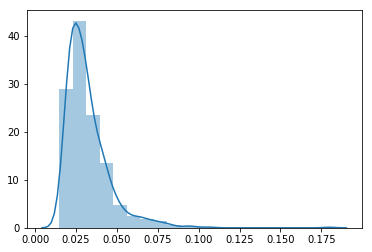

In [36]:
sns.distplot(out_stddev[:,0], bins = 20)

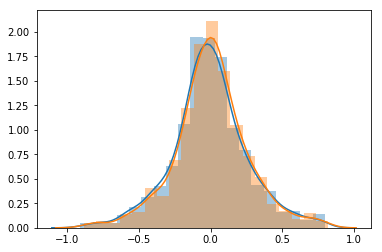

In [37]:
sns.distplot(out_mean[:,0], bins = 20)
sns.distplot(test_labels[:, 0], bins = 20)

### One sampling for 1000 images (ten batch)

Text(0.5, 1.0, '$z$')

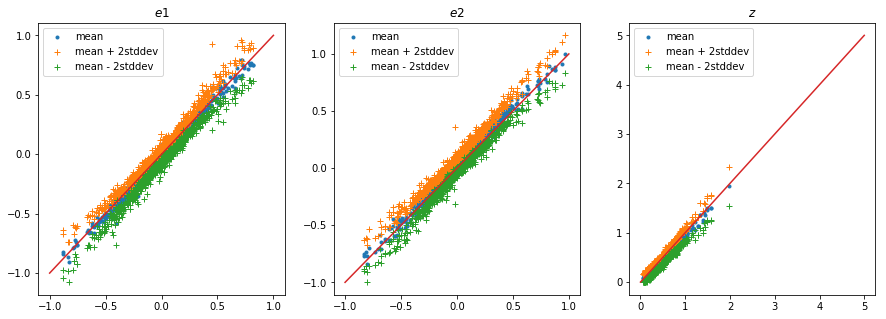

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(test_labels[:, 0], out_mean[:,0], '.', label = 'mean')
axes[0].plot(test_labels[:, 0], out_mean[:,0]+ 2*out_stddev[:,0], '+', label = 'mean + 2stddev')
axes[0].plot(test_labels[:, 0], out_mean[:,0]- 2*out_stddev[:,0], '+', label = 'mean - 2stddev')
x = np.linspace(-1,1)
axes[0].plot(x, x)
axes[0].legend()
#axes[0].set_ylim(-0.5,6.5)
axes[0].set_title('$e1$')

axes[1].plot(test_labels[:, 1], out_mean[:,1], '.', label = 'mean')
axes[1].plot(test_labels[:, 1], out_mean[:,1]+ 2*out_stddev[:,1], '+', label = 'mean + 2stddev')
axes[1].plot(test_labels[:, 1], out_mean[:,1]- 2*out_stddev[:,1], '+', label = 'mean - 2stddev')
x = np.linspace(-1,1)
axes[1].plot(x, x)
axes[1].legend()
#axes[1].set_ylim(-0.5,6.5)
axes[1].set_title('$e2$')

axes[2].plot(test_labels[:,2], out_mean[:,2], '.', label = 'mean')
axes[2].plot(test_labels[:,2], out_mean[:,2]+ 2*out_stddev[:,2], '+', label = 'mean + 2stddev')
axes[2].plot(test_labels[:,2], out_mean[:,2]- 2*out_stddev[:,2], '+', label = 'mean - 2stddev')
x = np.linspace(0,5)
axes[2].plot(x, x)
axes[2].legend()
#axes[2].set_ylim(-1,5.5)
axes[2].set_title('$z$')

#### Distribution

In [48]:
N = 100
means_e1 = np.zeros((N,100))
stddevs_e1 = np.zeros((N,100))
means_e2 = np.zeros((N,100))
stddevs_e2 = np.zeros((N,100))
means_z = np.zeros((N,100))
stddevs_z = np.zeros((N,100))

outs = np.zeros((N,100))
for i in range (N):
    out = net(test_data[:100])
    outs[i] = out[:,0].numpy()
    means_e1[i] = out.mean().numpy()[:,0]
    stddevs_e1[i] = out.stddev().numpy()[:,0]
    means_e2[i] = out.mean().numpy()[:,1]
    stddevs_e2[i] = out.stddev().numpy()[:,1]
    means_z[i] = out.mean().numpy()[:,2]
    stddevs_z[i] = out.stddev().numpy()[:,2]

In [54]:
image_nb = 3

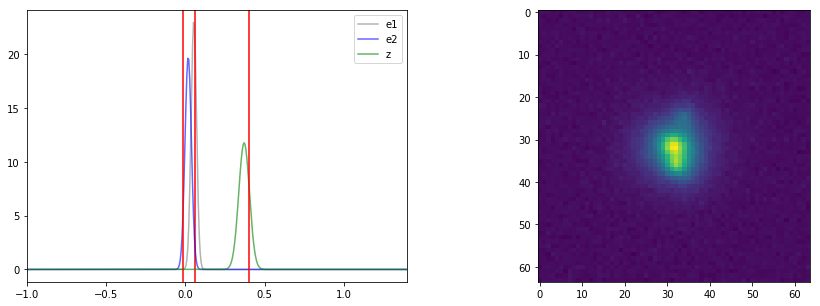

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(-1,5, 1000)


axes[0].plot(x, (1/(stddevs_e1[0,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e1[0,image_nb])/(2*stddevs_e1[0,image_nb]**2))), color = 'grey', alpha = 0.6, label = 'e1')
axes[0].axvline(test_labels[image_nb,0], color = 'r')

axes[0].plot(x, (1/(stddevs_e2[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e2[i,image_nb])/(2*stddevs_e2[i,image_nb]**2))), color = 'b', alpha = 0.6, label= 'e2')
axes[0].axvline(test_labels[image_nb,1], color = 'r')


axes[0].plot(x, (1/(stddevs_z[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_z[i,image_nb])/(2*stddevs_z[i,image_nb]**2))), color = 'green', alpha = 0.6, label= 'z')
axes[0].axvline(test_labels[image_nb,2], color = 'r')
axes[0].set_xlim(-1,test_labels[image_nb,2]+1)

axes[1].imshow(test_data[image_nb,:,:,2])
axes[0].legend()

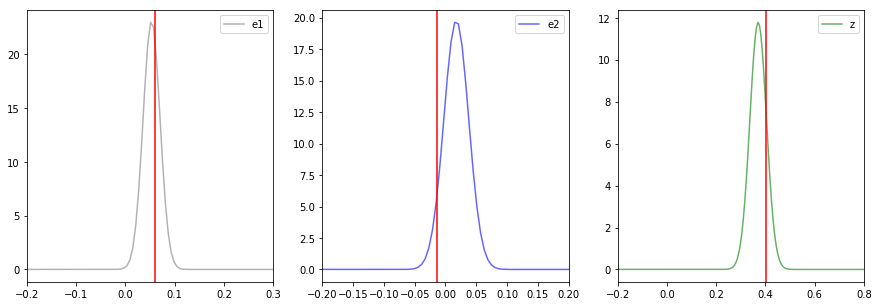

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x = np.linspace(-1,5, 1000)


axes[0].plot(x, (1/(stddevs_e1[0,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e1[0,image_nb])/(2*stddevs_e1[0,image_nb]**2))), color = 'grey', alpha = 0.6, label = 'e1')
axes[0].axvline(test_labels[image_nb,0], color = 'r')
axes[0].set_xlim(-0.2,0.3)

axes[1].plot(x, (1/(stddevs_e2[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e2[i,image_nb])/(2*stddevs_e2[i,image_nb]**2))), color = 'b', alpha = 0.6, label= 'e2')
axes[1].axvline(test_labels[image_nb,1], color = 'r')
axes[1].set_xlim(-0.2,0.2)

axes[2].plot(x, (1/(stddevs_z[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_z[i,image_nb])/(2*stddevs_z[i,image_nb]**2))), color = 'green', alpha = 0.6, label= 'z')
axes[2].axvline(test_labels[image_nb,2], color = 'r')
axes[2].set_xlim(-0.2,0.8)

#axes[1].imshow(test_data[image_nb,:,:,2])
axes[0].legend()
axes[1].legend()
axes[2].legend()

### Other example

In [137]:
image_nb = 1

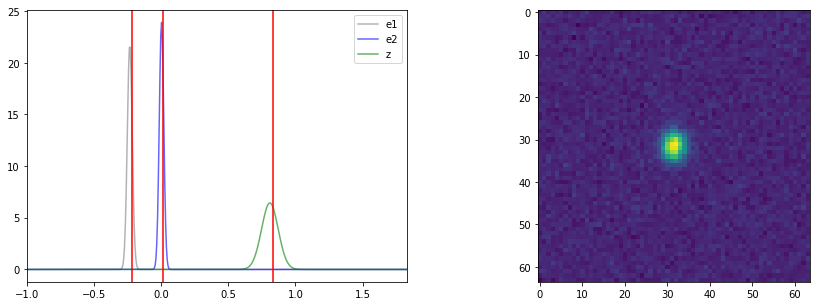

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(-1,5, 1000)


axes[0].plot(x, (1/(stddevs_e1[0,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e1[0,image_nb])/(2*stddevs_e1[0,image_nb]**2))), color = 'grey', alpha = 0.6, label = 'e1')
# mean_means = np.mean(means_e1[:,image_nb])
# mean_stddevs = np.mean(stddevs_e1[:,image_nb])
# axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,0], color = 'r')

axes[0].plot(x, (1/(stddevs_e2[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_e2[i,image_nb])/(2*stddevs_e2[i,image_nb]**2))), color = 'b', alpha = 0.6, label= 'e2')
# mean_means = np.mean(means_e2[:,image_nb])
# mean_stddevs = np.mean(stddevs_e2[:,image_nb])
# axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,1], color = 'r')


axes[0].plot(x, (1/(stddevs_z[i,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_z[i,image_nb])/(2*stddevs_z[i,image_nb]**2))), color = 'green', alpha = 0.6, label= 'z')
#mean_means = np.mean(means_z[:,image_nb])
#mean_stddevs = np.mean(stddevs_z[:,image_nb])
#axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'black', alpha = 1)    
axes[0].axvline(test_labels[image_nb,2], color = 'r')
axes[0].set_xlim(-1,test_labels[image_nb,2]+1)

axes[1].imshow(test_data[image_nb,:,:,2])
axes[0].legend()

# Comparison of with/without latent space

## One sampling for 1000 images (ten batch)

In [88]:
n = 10

In [89]:
test_data = np.zeros((n*batch_size, 64, 64, 6))
test_labels = np.zeros((n*batch_size, 3))

for i in range (n):
    test = test_generator.__getitem__(2)
    test_data[i*batch_size: (i+1)*batch_size] = test[0]
    test_labels[i*batch_size: (i+1)*batch_size] = test[1]

test_data.shape

(1000, 64, 64, 6)

In [90]:
out_with = net(test_data)
out_without = net_wo_ls(test_data)

E1

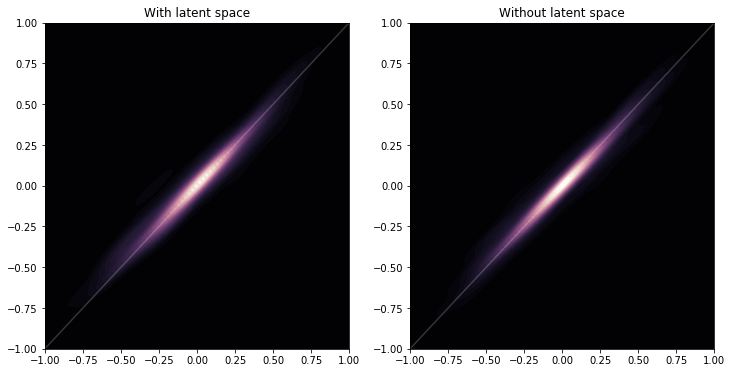

In [37]:
f, ax = plt.subplots(1,2,figsize=(12, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(test_labels[:, 0], out_with.mean().numpy()[:,0], cmap=cmap, n_levels=60, shade=True, ax = ax[0])
ax[0].set_title('With latent space')
x = np.linspace(-10,10,1000)
ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)
ax[0].plot(x,x, color = 'white', alpha = 0.2)

sns.kdeplot(test_labels[:, 0], out_without.mean().numpy()[:,0], cmap=cmap, n_levels=60, shade=True, ax = ax[1])
ax[1].set_title('Without latent space')
x = np.linspace(-10,10,1000)
ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)
ax[1].plot(x,x, color = 'white', alpha = 0.2)

E2

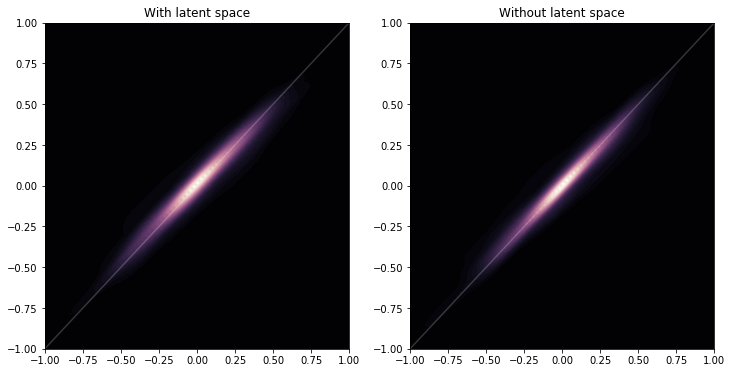

In [38]:
f, ax = plt.subplots(1,2,figsize=(12, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(test_labels[:, 1], out_with.mean().numpy()[:,1], cmap=cmap, n_levels=60, shade=True, ax = ax[0])
ax[0].set_title('With latent space')
x = np.linspace(-10,10,1000)
ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)
ax[0].plot(x,x, color = 'white', alpha = 0.2)
sns.kdeplot(test_labels[:, 1], out_without.mean().numpy()[:,1], cmap=cmap, n_levels=60, shade=True, ax = ax[1])
ax[1].set_title('Without latent space')
x = np.linspace(-10,10,1000)
ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)
ax[1].plot(x,x, color = 'white', alpha = 0.2)

Redshift

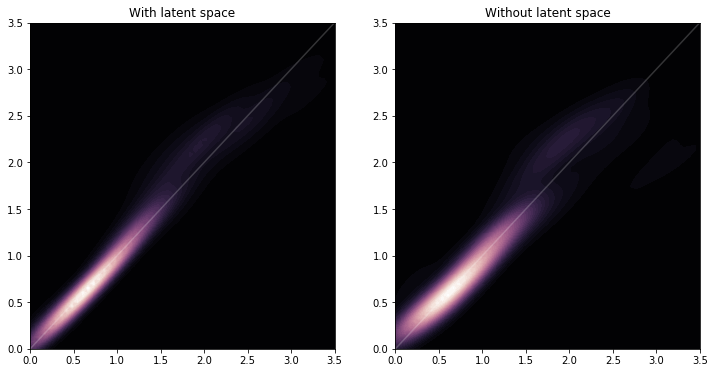

In [40]:
f, ax = plt.subplots(1,2,figsize=(12, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(test_labels[:, 2], out_with.mean().numpy()[:,2], cmap=cmap, n_levels=60, shade=True, ax = ax[0])
ax[0].set_title('With latent space')
x = np.linspace(-10,10,1000)
ax[0].set_xlim(0,3.5)
ax[0].set_ylim(0,3.5)
ax[0].plot(x,x, color = 'white', alpha = 0.2)
sns.kdeplot(test_labels[:, 2], out_without.mean().numpy()[:,2], cmap=cmap, n_levels=60, shade=True, ax = ax[1])
ax[1].set_title('Without latent space')
x = np.linspace(-10,10,1000)
ax[1].set_xlim(0,3.5)
ax[1].set_ylim(0,3.5)
ax[1].plot(x,x, color = 'white', alpha = 0.2)

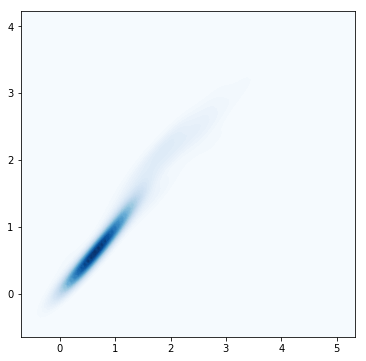

In [93]:
f, ax = plt.subplots(1,figsize=(6, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(test_labels[:, 2], out_with.mean().numpy()[:,2], cmap='Reds', n_levels=60, shade=True)
sns.kdeplot(test_labels[:, 2], out_with.mean().numpy()[:,2], cmap='Blues', n_levels=60, shade=True)
#ax.title('With latent space')
x = np.linspace(-10,10,1000)
#ax.xlim(0,3.5)
#ax.ylim(0,3.5)
#ax.plot(x,x, color = 'white', alpha = 0.2)


### N samplings for 100 images (one batch)

In [84]:
N = 100
means_with_e1 = np.zeros((N,100))
stddevs_with_e1 = np.zeros((N,100))
means_with_e2 = np.zeros((N,100))
stddevs_with_e2 = np.zeros((N,100))
means_with_z = np.zeros((N,100))
stddevs_with_z = np.zeros((N,100))

means_without_e1 = np.zeros((1,100))
stddevs_without_e1 = np.zeros((1,100))
means_without_e2 = np.zeros((1,100))
stddevs_without_e2 = np.zeros((1,100))
means_without_z = np.zeros((1,100))
stddevs_without_z = np.zeros((1,100))

outs_with = np.zeros((N,100))
for i in range (N):
    out_with = net(test_data[:100])
    outs_with[i] = out_with[:,0].numpy()
    means_with_e1[i] = out_with.mean().numpy()[:,0]
    stddevs_with_e1[i] = out_with.stddev().numpy()[:,0]
    means_with_e2[i] = out_with.mean().numpy()[:,1]
    stddevs_with_e2[i] = out_with.stddev().numpy()[:,1]
    means_with_z[i] = out_with.mean().numpy()[:,2]
    stddevs_with_z[i] = out_with.stddev().numpy()[:,2]

out_without = net_wo_ls(test_data[:100])
means_without_e1[0] = out_without.mean().numpy()[:,0]
stddevs_without_e1[0] = out_without.stddev().numpy()[:,0]
means_without_e2[0] = out_without.mean().numpy()[:,1]
stddevs_without_e2[0] = out_without.stddev().numpy()[:,1]
means_without_z[0] = out_without.mean().numpy()[:,2]
stddevs_without_z[0] = out_without.stddev().numpy()[:,2]


#### Distribution

e1: 0.5382068157196045 e0: -0.1400725394487381 redshift: 1.2489999532699585


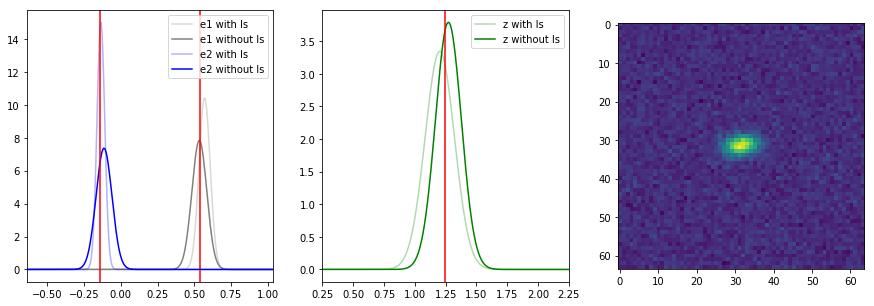

In [85]:
image_nb = 0

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x = np.linspace(-1,5, 1000)


axes[0].plot(x, (1/(stddevs_without_e1[0,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_without_e1[0,image_nb])/(2*stddevs_without_e1[0,image_nb]**2))), color = 'grey', alpha = 0.3, label = 'e1 with ls')
mean_means = np.mean(means_with_e1[:,image_nb])
mean_stddevs = np.mean(stddevs_with_e1[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'grey', alpha = 1, label = 'e1 without ls')    
axes[0].axvline(test_labels[image_nb,0], color = 'r')

axes[0].plot(x, (1/(stddevs_without_e2[0,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_without_e2[0,image_nb])/(2*stddevs_without_e2[0,image_nb]**2))), color = 'b', alpha = 0.3, label= 'e2 with ls')
mean_means = np.mean(means_with_e2[:,image_nb])
mean_stddevs = np.mean(stddevs_with_e2[:,image_nb])
axes[0].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'b', alpha = 1, label = 'e2 without ls')    
axes[0].axvline(test_labels[image_nb,1], color = 'r')
axes[0].set_xlim(np.min((test_labels[image_nb,0]-0.5, test_labels[image_nb,1]-0.5)),np.max((test_labels[image_nb,0]+0.5, test_labels[image_nb,1]+0.5)))

axes[1].plot(x, (1/(stddevs_without_z[0,image_nb]*np.sqrt(2*np.pi))*np.exp(-np.square(x-means_without_z[0,image_nb])/(2*stddevs_without_z[0,image_nb]**2))), color = 'green', alpha = 0.3, label= 'z with ls')
mean_means = np.mean(means_with_z[:,image_nb])
mean_stddevs = np.mean(stddevs_with_z[:,image_nb])
axes[1].plot(x, (1/(mean_stddevs*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean_means)/(2*mean_stddevs**2))), color = 'green', alpha = 1, label= 'z without ls')    
axes[1].axvline(test_labels[image_nb,2], color = 'r')
axes[1].set_xlim(test_labels[image_nb,2]-1,test_labels[image_nb,2]+1)

axes[2].imshow(test_data[image_nb,:,:,2])
axes[0].legend()
axes[1].legend()

print('e1: '+str(test_labels[image_nb,0]), 'e0: '+str(test_labels[image_nb,1]),'redshift: ' +str(test_labels[image_nb,2]))